<a href="https://colab.research.google.com/github/derek-shing/DS-Sprint-01-Dealing-With-Data/blob/master/module4-databackedassertions/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [2]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [11]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [12]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have twice as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.2 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=84.45683142093522, mobile=True), User(purchased=False, time_on_site=266.20100369227873, mobile=True), User(purchased=False, time_on_site=172.20578690750943, mobile=True), User(purchased=False, time_on_site=143.10792150992785, mobile=False), User(purchased=False, time_on_site=87.11499845648113, mobile=False), User(purchased=True, time_on_site=80.34668438127794, mobile=True), User(purchased=True, time_on_site=146.82774929359192, mobile=True), User(purchased=True, time_on_site=224.1769644964444, mobile=True), User(purchased=False, time_on_site=214.98465617757242, mobile=False), User(purchased=False, time_on_site=185.90616420664134, mobile=True)]


In [13]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,84.456831,True
1,False,266.201004,True
2,False,172.205787,True
3,False,143.107922,False
4,False,87.114998,False


In [14]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.000279625476151,5.37319718745348,5.502727315003718,6.117791312183877,6.271644072425184,6.364955915319118,7.051848726301555,7.382992573392057,7.926582745229904,9.079470987047848,...,584.0923489211018,586.1107459361461,586.2050312558629,588.2826829340846,589.3818877090235,589.4444789211508,591.2637081633362,593.0065879586617,593.7631158563894,598.7762417817848
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,1,1,0
True,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [15]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.407, 123.755]","(123.755, 242.511]","(242.511, 361.266]","(361.266, 480.021]","(480.021, 598.776]"
purchased,,,,,
False,259,276,185,50,44
True,68,67,36,10,5


In [16]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.407, 123.755]","(123.755, 242.511]","(242.511, 361.266]","(361.266, 480.021]","(480.021, 598.776]"
purchased,,,,,
False,0.792049,0.804665,0.837104,0.833333,0.897959
True,0.207951,0.195335,0.162896,0.166667,0.102041


In [17]:
# That seems counter to our hypothesis
# More time on the site seems to have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.868,0.796
True,0.132,0.204


In [18]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

group = user_data.groupby('mobile')
group.get_group(False)

#group_dict=dict(list(group))

#group_dict[False]



,purchased,time_on_site,mobile
3,False,143.107922,False
4,False,87.114998,False
8,False,214.984656,False
12,False,158.742824,False
14,False,223.214094,False
23,False,224.248877,False
24,False,351.685169,False
25,False,25.073926,False
37,False,337.543070,False
47,False,414.391317,False


## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [76]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

import pandas as pd
import matplotlib.pyplot as plt
#!wget https://github.com/derek-shing/DS-Sprint-01-Dealing-With-Data/blob/master/module4-databackedassertions/persons.csv
#!ls

df= pd.read_csv('https://raw.githubusercontent.com/coding-ss/DS-Sprint-01-Dealing-With-Data/master/module4-databackedassertions/persons.csv')


df.head()

#df.isnull().sum()



,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


               Unnamed: 0       age    weight  exercise_time
Unnamed: 0       1.000000 -0.000418 -0.060297      -0.020138
age             -0.000418  1.000000  0.144168      -0.273818
weight          -0.060297  0.144168  1.000000      -0.478021
exercise_time   -0.020138 -0.273818 -0.478021       1.000000


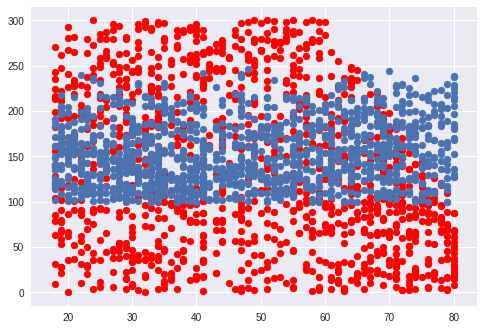

In [118]:

plt.scatter(df.age,df.exercise_time ,c='r')
plt.scatter(df.age,df.weight)

print(df.corr())

weight,"(99.854, 118.25]","(118.25, 136.5]","(136.5, 154.75]","(154.75, 173.0]","(173.0, 191.25]","(191.25, 209.5]","(209.5, 227.75]","(227.75, 246.0]"
exercise_time,,,,,,,,
"(-0.3, 37.5]",22,20,24,20,28,30,23,24
"(37.5, 75.0]",22,18,20,25,25,24,26,4
"(75.0, 112.5]",23,28,32,42,32,28,17,0
"(112.5, 150.0]",26,23,18,24,24,25,2,0
"(150.0, 187.5]",29,26,39,24,24,5,0,0
"(187.5, 225.0]",31,34,23,18,8,0,0,0
"(225.0, 262.5]",29,34,33,25,0,0,0,0
"(262.5, 300.0]",40,49,24,6,0,0,0,0


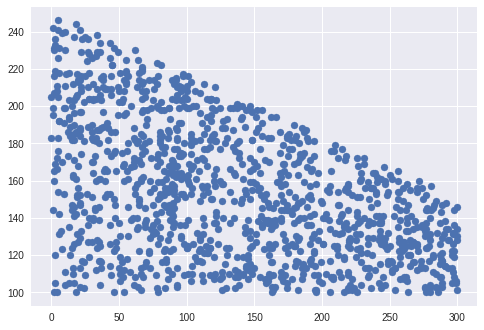

In [78]:
plt.scatter(df.exercise_time,df.weight)


age_interval = pd.interval_range(start=0,end=100,freq=10)
age_group = pd.cut(df.age,bins=age_interval,labels=["Under 10", "10s", "20s", "30s", "40s", "50s", "60s", "70s", "80s", "90s"])
weight_group= pd.cut(df.weight,8)
ex_group= pd.cut(df.exercise_time,8)

pd.crosstab(ex_group,weight_group)

(0, 10]


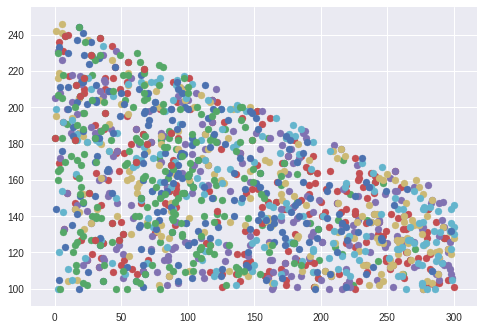

In [116]:
##Try to plot the weight vs exercis time graph for each age group

age_interval = pd.interval_range(start=0,end=100,freq=10, name=["Under 10", "10s", "20s", "30s", "40s", "50s", "60s", "70s", "80s", "90s"])

print(age_interval[0])
df['age_group']=pd.cut(df.age,bins=age_interval,labels=["Under 10", "10s", "20s", "30s", "40s", "50s", "60s", "70s", "80s", "90s"]).astype(str)

#df.info()
#print(df.head())
#df.loc[df['age'] in (age_interval[0])]

#df.set_index('age_group', inplace=True, drop=False)
#df
#df.loc[df['age'] in (age_group[3])]

df0 = df[df['age'].between(0,10,inclusive=True)]
df10 = df[df['age'].between(10,20,inclusive=True)]
df20 = df[df['age'].between(20,30,inclusive=True)]
df30 = df[df['age'].between(30,40,inclusive=True)]
df40 = df[df['age'].between(40,50,inclusive=True)]
df50 = df[df['age'].between(50,60,inclusive=True)]
df60 = df[df['age'].between(60,70,inclusive=True)]
df70 = df[df['age'].between(70,80,inclusive=True)]
df80 = df[df['age'].between(80,90,inclusive=True)]
df90 = df[df['age'].between(90,100,inclusive=True)]

plt.scatter(df0.exercise_time,df0.weight)
plt.scatter(df10.exercise_time,df10.weight)
plt.scatter(df20.exercise_time,df20.weight)
plt.scatter(df30.exercise_time,df30.weight)
plt.scatter(df40.exercise_time,df40.weight)
plt.scatter(df50.exercise_time,df50.weight)
plt.scatter(df60.exercise_time,df60.weight)
plt.scatter(df70.exercise_time,df70.weight)
plt.scatter(df80.exercise_time,df80.weight)
plt.scatter(df90.exercise_time,df90.weight)

###   different color of the dot represent different age group ###

#df.groupby([age_group]).get_group(age_interval[0])
#groups = dict(list(group_df))
#groups
#print(groups[age_interval[0]])

#Interval(0, 10, closed='right')

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?

**All of the variables are continous variable**

2.  What are the relationships between the variables?

The pair of variables have the highest absolute correlation value are 'weight' and 'exercise_time', which is -0.47. The weight is decreasing when exercies time increase.
There is no obvious relation between all other pair of variable


3.  Which relationships are "real", and which spurious?

**The relationships between weight and exercise time is real.**


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspierd by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)